In [1]:
import require

get_training_data = require.single( "get_training_data" )
dataframes = get_training_data( )

  0%|                                                                                                            | 0/11 [00:00<?, ?it/s]

  9%|█████████                                                                                           | 1/11 [00:03<00:32,  3.29s/it]

 18%|██████████████████▏                                                                                 | 2/11 [00:06<00:28,  3.14s/it]

 27%|███████████████████████████▎                                                                        | 3/11 [00:09<00:23,  2.99s/it]

 36%|████████████████████████████████████▎                                                               | 4/11 [00:12<00:20,  2.96s/it]

 45%|█████████████████████████████████████████████▍                                                      | 5/11 [00:15<00:18,  3.01s/it]

 55%|██████████████████████████████████████████████████████▌                                             | 6/11 [00:18<00:15,  3.02s/it]

 64%|███████████████████████████████████████████████████████████████▋                                    | 7/11 [00:20<00:11,  2.93s/it]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 8/11 [00:23<00:08,  2.90s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 9/11 [00:26<00:05,  2.90s/it]

 91%|██████████████████████████████████████████████████████████████████████████████████████████         | 10/11 [00:29<00:02,  2.91s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.96s/it]


In [2]:
train_ensemble = require.single( "train_ensemble" )
ensemble = train_ensemble( dataframes[ :-1 ])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]
lhs shape = (1576, 887)
lhs rank = 789
degrees of freedom = 887
new_deaths_smoothed_per_million


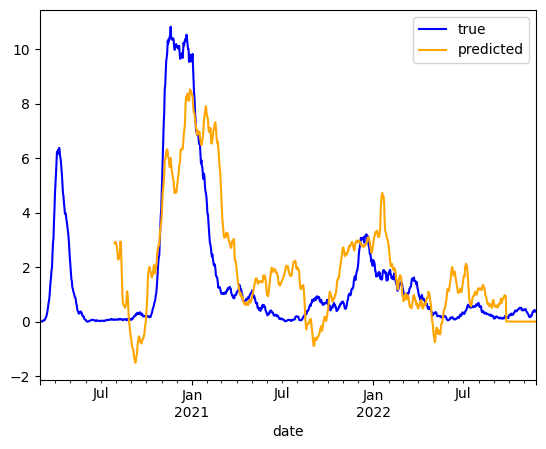

In [3]:
import matplotlib.pyplot as plt
predict_replace = require.single( "predict_replace" )

time_range = slice( 0, 1000 )
column = 1
df = dataframes[ 1 ]

df_pred = predict_replace( df, ensemble )
df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )

line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )
print( df_pred.columns[ column ])